# Multi Salmo microbetag networks analysis

## Functions

Load dependencies

In [1]:
# General
import os
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
import plotly.io as pio
import plotly.express as px
import webbrowser


import numpy as np


from utils import *

In [2]:
# Load the datasets
genome_taxonomy = pd.read_csv("../data/gtdbtk.summary.tsv", sep="\t")
genome_quality = pd.read_csv("../data/genomeInfo.csv")

selected_genomes = pd.read_csv("../data/Wdb.csv")
selected_genomes["genome"] = selected_genomes["genome"].str.replace(".fa", "", regex=True)
selected_genomes = selected_genomes["genome"]

# Modify genome names
genome_taxonomy['genome'] = genome_taxonomy['user_genome'].str.replace('.fa', '', regex=True)

genome_taxonomy = genome_taxonomy[genome_taxonomy['genome'].isin(selected_genomes)]

# Split the classification into separate columns
genome_taxonomy[['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']] = genome_taxonomy['classification'].str.split(';', expand=True)

# Select the relevant columns
genome_taxonomy = genome_taxonomy[['genome', 'domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']]

# Process genome quality data
genome_quality['genome'] = genome_quality['genome'].str.replace('.fa', '', regex=True)

# Filter only selected genomes (the 223 species-representatives)
genome_quality = genome_quality[genome_quality['genome'].isin(selected_genomes)]

# Select relevant columns
genome_quality = genome_quality[['genome', 'completeness', 'contamination', 'length']]

# Merge the two dataframes on the 'genome' column
genome_metadata = pd.merge(genome_taxonomy, genome_quality, on='genome', how='left')

In [3]:
genome_taxonomy.head()
genome_quality.head()
genome_metadata.head()

,genome,domain,phylum,class,order,family,genus,species,completeness,contamination,length
0,D300418:bin_000001,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__Faeciplasma,s__Faeciplasma gallinarum,99.49,0.17,1791036
1,D300418:bin_000013,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Oscillospirales,f__Acutalibacteraceae,g__Fimivicinus,s__Fimivicinus intestinavium,81.41,1.94,2332804
2,D300428:bin_000008,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Christensenellales,f__Borkfalkiaceae,g__Coproplasma,s__Coproplasma excrementigallinarum,82.32,3.54,1922776
3,D300430:bin_000010,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Oscillospirales,f__Oscillospiraceae,g__Intestinimonas,s__Intestinimonas timonensis,83.60,7.68,3001106
4,D300432:bin_000001,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Lachnospirales,f__Anaerotignaceae,g__Fimicola,s__Fimicola sp944379995,95.93,0.97,2795297


Functions for the needs of the stats.

## Discussing the nets

***Salmonella*** is *positively* associated with **lactic acid**; in agreement with in vitro data. 

It’s also *negatively* associated with ***Lactobacillus johnsonii***, with a stronger negative than positive seed score. That means that *Lactobacillus johnsonii* is another probiotic candidate species.

*Salmonella* is also *negatively* associated with **time**, which is not unexpected.

***Ligilactobacillus salivarius*** (PoultryStar member) is *positively* associated to **synbiont-water**, in addition to **TG4** (no PoultryStar), so it does show up in some chickens supposed to have received it. 
Maybe that means that it is present in some hosts prior to treatment. 

**TG1** is linked to *Tyzzerella sp.* both in the global network and day 7 network.

Early days are more strongly shaped by treatment groups than later days.

Also, there are more taxon-metabolite associations in later days, with a peak in day 21.

There is a jump in node and edge number from 7 to 21 days, though the overall (Pearson) correlation of day to edge or node number is not significant.
Thus, the network gets more complex with changing feeding habits.


It seems that from day 28 to 35, even the number of edges is decreasing, the potential cross feedings are increased.

## Stats

### Prep

Keep track of the non-sequence nodes.

In [4]:
env_var = ["treatment_TG1", "treatment_TG2", "treatment_TG3", "treatment_TG4", "treatment_TG5", 
           "day", "salmonella", "synbiotic_water", "synbiotic_feed"
]
metabolites = [
"L-Tyrosine", "L-Phenylalanine", "L-Tryptophan", "L-Aspartic Acid", "L-Arginine", "L-Leucine", "L-Glutamic acid", "L-Glutamine", 
"L-Histidine", "L-Lysine", "L-Methionine", "L-Proline", "L-Threonine", "Thiamine", "Adenine", 'Guanosine', "L-Valine" , "L-Alanine", 
"L-Asparagine", "L-Isoleucine", "L-Serine", "Lactic acid", "Sulfoacetic acid"
]
env_set = set(env_var)
metabolites_set = set(metabolites)

In [5]:
root_dir = os.getcwd()
cx_dir = os.path.join(root_dir, "microbetag_nets")

In [6]:
cx_overall_filepath = os.path.join(cx_dir, "overall.cx2")
cx_overall = load_cx2(cx_overall_filepath)
overall_mtg = MggParser(cx_overall, env_set, metabolites_set),

### Per day networks

#### Prep

Calculate statistics on the microbetag-annotated networks per day.

Load the `.cx2` files 

In [7]:
cx_07_filepath = os.path.join(cx_dir, "microbetag_net_day_7.cx2")  ; cx_07 = load_cx2(cx_07_filepath)
cx_14_filepath = os.path.join(cx_dir, "microbetag_net_day_14.cx2") ; cx_14 = load_cx2(cx_14_filepath)
cx_21_filepath = os.path.join(cx_dir, "microbetag_net_day_21.cx2") ; cx_21 = load_cx2(cx_21_filepath)
cx_28_filepath = os.path.join(cx_dir, "microbetag_net_day_28.cx2") ; cx_28 = load_cx2(cx_28_filepath)
cx_35_filepath = os.path.join(cx_dir, "microbetag_net_day_35.cx2") ; cx_35 = load_cx2(cx_35_filepath)

Example of how an edge looks like on the `.cx2` format.
```json

// Edge example
    {'id': 245,
    's': 83,
    't': 2,
    'v': {'interaction type': 'cooccurrence',
    'microbetag::weight': 0.9523214101791382,
    'shared name': 'L-Leucine (cooccurss with) L-Isoleucine'}}

```

In [8]:
days = [7, 14, 21, 28, 35]

#### Count the number of **taxon-metabolite associations** in the day-specific networks and correlate it with day

In [9]:
days_parsed_nets = {
    "day07" : MggParser(cx_07, env_set, metabolites_set),
    "day14" : MggParser(cx_14, env_set, metabolites_set),
    "day21" : MggParser(cx_21, env_set, metabolites_set),
    "day28" : MggParser(cx_28, env_set, metabolites_set),
    "day35" : MggParser(cx_35, env_set, metabolites_set)
}

In [10]:
taxon_to_metabo_hits = [
    net.edge_types["taxon_to_metabo"]["counts"] for _, net in days_parsed_nets.items()
]
taxon_to_metabo_hits

[8, 5, 26, 12, 9]

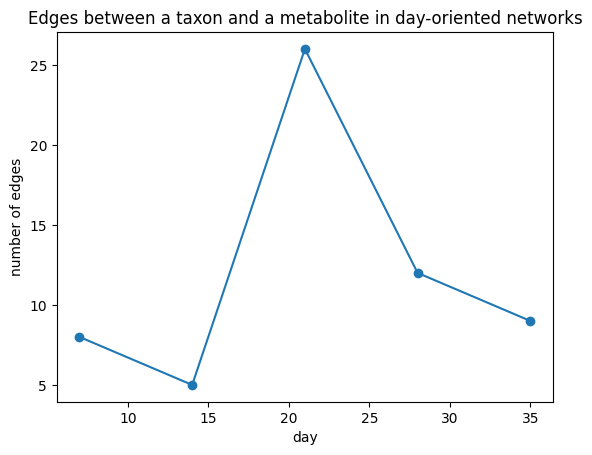

In [11]:
# What to plot
plt.plot(days, taxon_to_metabo_hits, marker='o', linestyle='-')
# Labels and title
plt.xlabel("day")
plt.ylabel("number of edges")
plt.title("Edges between a taxon and a metabolite in day-oriented networks")
# Show time
plt.show()


#### Count the number of taxon-treatment associations in the day-specific networks

In [12]:
taxon_to_env_hits = [
    net.edge_types["taxon_to_env"]["counts"] for _, net in days_parsed_nets.items()
]

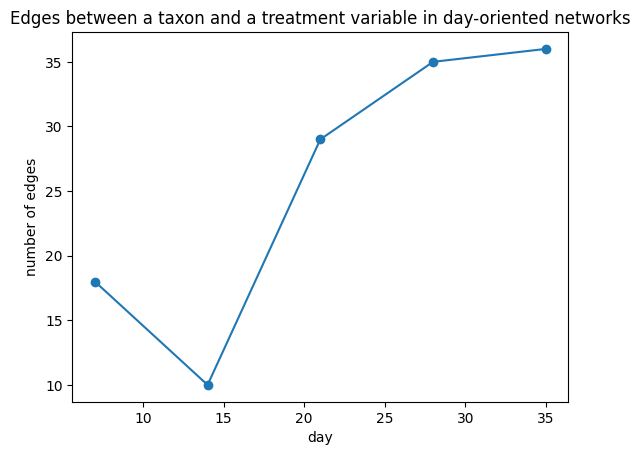

In [13]:
# What to plot
plt.plot(days, taxon_to_env_hits, marker='o', linestyle='-')
# Labels and title
plt.xlabel("day")
plt.ylabel("number of edges")
plt.title("Edges between a taxon and a treatment variable in day-oriented networks")
# Show time
plt.show()

#### Correlate time vs total number of cross-feedings across day-specific networks

In [12]:
overall_number_of_seed_compl = [
    sum(net.num_total_compls.values()) for _, net in days_parsed_nets.items()
]

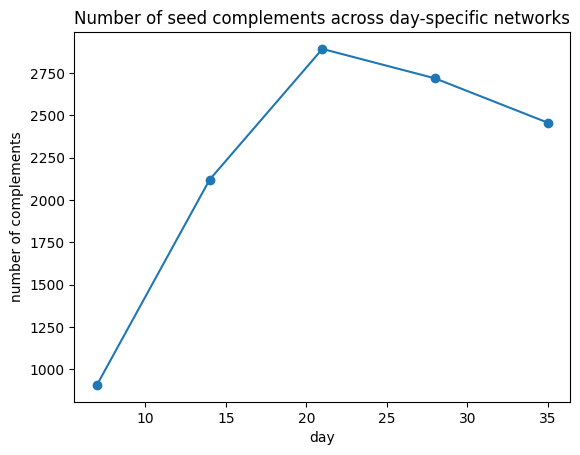

In [15]:
# What to plot
plt.plot(days, overall_number_of_seed_compl, marker='o', linestyle='-')
# Labels and title
plt.xlabel("day")
plt.ylabel("number of complements")
plt.title("Number of seed complements across day-specific networks")
# Show time
plt.show()

#### Correlation between number of positive taxon-to-taxon edged and predicted cross-feedings in day-specific networks 

In [14]:
number_of_seed_compl_per_day_in_positive_associated_taxa = [
    get_compls_and_compounds_in_positive_associated_taxa(
        net.cx2, 
        net.pos_pairs_node_ids, 
        net.num_total_compls, 
        net.edge_id_to_unique_compounds
        )[0] 
    for _, net in days_parsed_nets.items()
]

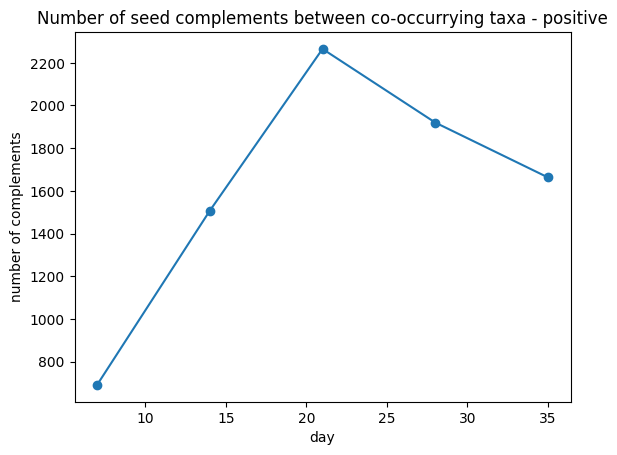

In [17]:
# What to plot
plt.plot(days, number_of_seed_compl_per_day_in_positive_associated_taxa, marker='o', linestyle='-')
# Labels and title
plt.xlabel("day")
plt.ylabel("number of complements")
plt.title("Number of seed complements between co-occurrying taxa - positive")
# Show time
plt.show()

In [18]:
mean_of_seed_compl_in_positive_associated_taxa = [
    number_of_seed_compl_per_day_in_positive_associated_taxa[index] / len(net.pos_pairs_node_ids) for index, net in enumerate(days_parsed_nets.values())
]
mean_overall_number_of_seed_compl = [
    overall_number_of_seed_compl[index] /  len(net.num_total_compls)  for index, net in enumerate(days_parsed_nets.values())
]

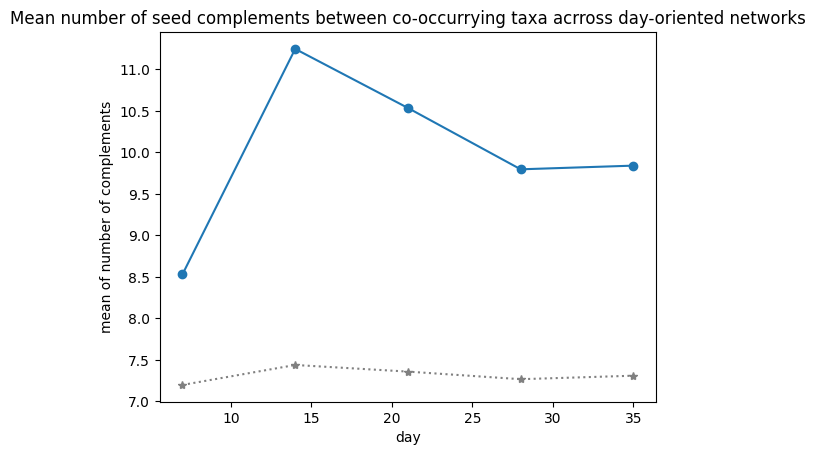

In [19]:
# What to plot
plt.plot(days, mean_of_seed_compl_in_positive_associated_taxa, marker='o', linestyle='-', label="between co-occurrying taxa")
plt.plot(days, mean_overall_number_of_seed_compl, marker="*", linestyle="dotted", color="grey", label="overall taxon-to-taxon")
# Labels and title
plt.xlabel("day")
plt.ylabel("mean of number of complements")
plt.title("Mean number of seed complements between co-occurrying taxa acrross day-oriented networks")
# Show time
plt.show()

#### Unique compounds involved in potential cross-feedings

In [15]:
unique_compounds_in_cf_of_positive_associated_taxa = [
    get_compls_and_compounds_in_positive_associated_taxa(
        net.cx2, 
        net.pos_pairs_node_ids, 
        net.num_total_compls, 
        net.edge_id_to_unique_compounds
        )[1]
    for _, net in days_parsed_nets.items()
]

In [16]:
lengths = [
    len(x) for x in unique_compounds_in_cf_of_positive_associated_taxa
]

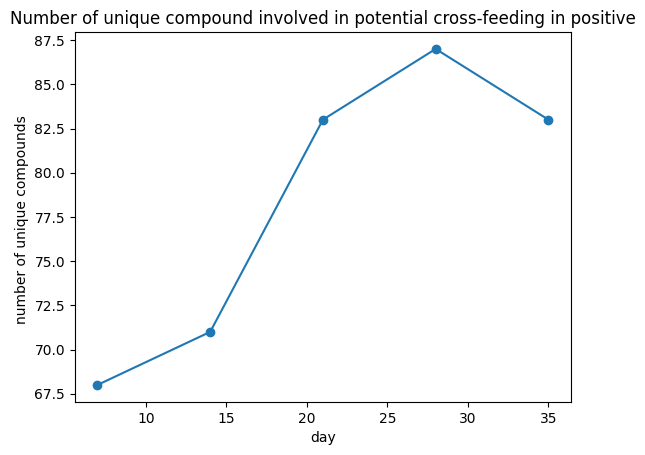

In [22]:
plt.plot(days, lengths, marker='o', linestyle='-')

# Labels and title
plt.xlabel("day")
plt.ylabel("number of unique compounds ")
plt.title("Number of unique compound involved in potential cross-feeding in positive")

# Show the plot
plt.show()

In [17]:
day_set = { "day_" + str(i): j for i,j in zip(days, unique_compounds_in_cf_of_positive_associated_taxa)}

In [18]:
venn(day_set)
plt.title("Overlap of the compounds involved in the potential cross-feeding interactions across the per-day networks")

# Show the plot
plt.show()

TypeError: 'module' object is not callable

In [19]:
day7 = days_parsed_nets["day07"]

In [ ]:
# node ids 15-112 both in cooccurence and complets/copmetes
day7.cx2.get_edges()

{0: {'id': 0,
  's': 15,
  't': 112,
  'v': {'interaction type': 'cooccurrence',
   'microbetag::weight': 0.8644246459007263,
   'shared name': 'D300452:bin_000016 (cooccurss with) D300511:bin_000016'}},
 1: {'id': 1,
  's': 112,
  't': 15,
  'v': {'interaction type': 'completes/competes with',
   'shared name': 'D300452:bin_000016 (completes/competes with) D300511:bin_000016',
   'compl::D300452:bin_000016:D300511:bin_000016': ['M00001^Glycolysis (Embden-Meyerhof pathway): glucose^Carbohydrate metabolism^K00873^K25026;K01810;K21071;K01624;K01803;K00134;K00927;K15633;K01689;K00873^https://tinyurl.com/2b3zlstu',
    'M00002^Glycolysis: core module involving three-carbon compounds^Carbohydrate metabolism^K00873^K01803;K00134;K00927;K15633;K01689;K00873^https://tinyurl.com/28dd2u82',
    'M00007^Pentose phosphate pathway: non-oxidative phase^Carbohydrate metabolism^K00616^K00615;K00616;K01783;K01808^https://tinyurl.com/24ttn6vz',
    'M00526^Lysine biosynthesis: DAP dehydrogenase pathway^

In [20]:
dfs = []

ratio_ggplots = []


for idx, day in enumerate(days_parsed_nets):                      # # NOTE (Haris Zafeiropoulos, 2025-04-02):  Enumerate will keep the same order as long as we do not edit the days_parased_nets dictionary

    day_net = days_parsed_nets[day]

    rplot, df = process_cooccurrence_and_regression(
        day_net, day, metabolites, env_set
    )

    ratio_ggplots.append(rplot)

    dfs.append(df)


In [21]:
for index, plot in enumerate(ratio_ggplots):
    
    ggsave(plot, filename=f"figs/seed_stats/compls_per_neighbor_wls_{days[index]}.svg", width=8, height=8, format="svg", dpi=300)

/home/luna.kuleuven.be/u0156635/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 8 in image.
/home/luna.kuleuven.be/u0156635/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figs/seed_stats/compls_per_neighbor_wls_7.svg
/home/luna.kuleuven.be/u0156635/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 8 in image.
/home/luna.kuleuven.be/u0156635/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figs/seed_stats/compls_per_neighbor_wls_14.svg
/home/luna.kuleuven.be/u0156635/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 8 in image.
/home/luna.kuleuven.be/u0156635/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figs/seed_stats/compls_per_neighbor_wls_21.svg
/home/luna.kuleuven.be/u0156635/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning

In [22]:
rplot, df = process_cooccurrence_and_regression(
        overall_mtg[0], "overall", metabolites, env_set
    )


In [23]:
ggsave(rplot, filename="figs/seed_stats/compls_per_neighbor_wls_overall.svg", width=8, height=8, format="svg", dpi=300)

/home/luna.kuleuven.be/u0156635/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 8 in image.
/home/luna.kuleuven.be/u0156635/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figs/seed_stats/compls_per_neighbor_wls_overall.svg


Use the genome metadata `df` we built in the beginning of the notebook, to get the genome size of each MAG.

In [24]:
for df in dfs:
    df["genome size"] = df["name"].map(genome_metadata.set_index("genome")["length"])
    df.rename(columns={"neighbors_num": "number of neighbors", "compl_ratio": "seed complements per neighbor"}, inplace=True)
df.head()

,id,number of neighbors,neighbors,seed_compls_num,name,species,family,order,day,seed complements per neighbor,genome size
84,84,2,"{196, 7}",31,D300526:bin_000014,s__Blautia stercorigallinarum,f__Lachnospiraceae,o__Lachnospirales,day35,15.500000,3288674
196,196,3,"{84, 182, 102}",36,D300458:bin_000001,s__Coproplasma stercorigallinarum,f__Borkfalkiaceae,o__Christensenellales,day35,12.000000,1947586
39,39,2,"{124, 167}",17,D300428:bin_000008,s__Coproplasma excrementigallinarum,f__Borkfalkiaceae,o__Christensenellales,day35,8.500000,1922776
167,167,3,"{16, 163, 39}",28,D300435:bin_000001,s__Anaerotignum merdipullorum,f__Anaerotignaceae,o__Lachnospirales,day35,9.333333,2545646
174,174,2,"{162, 4}",11,D300499:bin_000015,s__Caccovicinus sp017889125,f__Lachnospiraceae,o__Lachnospirales,day35,5.500000,4069219


In [51]:
# Create 3D scatter plot
fig = px.scatter_3d(df, 
                     x='number of neighbors', 
                     y='seed complements per neighbor', 
                     z='genome size', 
                     color='order',  
                     symbol='order',  
                     size_max=10,
                     opacity=0.8)


In [52]:
# Save the plot as an HTML file
html_file = "plotly_3d_plot.html"
fig.write_html(html_file)

# Open the HTML file in the default web browser
webbrowser.open(html_file)

True

Opening in existing browser session.


After I open the `.html` file on my browser, I turned it around a bit and I extracted its ***camera settings*** by moving to the *Inspect* and running the following command on the `Console`:


    JSON.stringify(document.querySelector("div.js-plotly-plot")._fullLayout.scene.camera)


In [ ]:
camera_settings = {
    "up":{"x":0,"y":0,"z":1},
    "center":{"x":0,"y":0,"z":0},
    "eye":{"x":-1.0142173958395229,"y":1.6792529527047904,"z":0.9159544720174357},
    "projection":{"type":"perspective"}
}


In [ ]:
fig.update_layout(
    scene_camera=camera_settings,
    width=1200,  # Width of the figure in pixels
    height=1000,  # Height of the figure in pixels
    plot_bgcolor='rgba(0, 0, 0, 0)',  # Transparent background for the plot area
    paper_bgcolor='rgba(0, 0, 0, 0)',  # Transparent background for the surrounding area
    font=dict(size=14),  # Increase font size for axes and other text elements
    title_font = {"size": 40},
    yaxis_title_font=dict(size=20)   # Increase font size for y-axis label
)

fig.update_xaxes(title='New x label')


# Save the figure as an SVG file
pio.write_image(fig, "plot.svg")

In [ ]:
# cx_07
# days_parsed_nets["day07"].edge_types.keys()

taxa_pair_2_edge_id = {}
for edge_id in cx_07.get_edges():
    edge = cx_07.get_edge(edge_id)    
    pair = (edge["s"], edge["t"])
    if edge["v"]["interaction type"] != "completes/competes with":    
        taxa_pair_2_edge_id[pair] = edge_id


pos_weight_scores, neg_weight_scores = {}, {}
for edge_id in days_parsed_nets["day07"].edge_types["taxon_to_taxon"]["edges"]:
    edge = cx_07.get_edge(edge_id)
    if edge["v"]["interaction type"] in ["cooccurrence", "depletion"]:
        continue

    comp, coop, s, t = edge["v"]["seed::competition"], edge["v"]["seed::cooperation"], edge["s"], edge["t"]
    eid = taxa_pair_2_edge_id.get((s, t), taxa_pair_2_edge_id.get((t, s)))

    flashweave_score = cx_07.get_edge(eid)["v"]["microbetag::weight"]
    target = pos_weight_scores if flashweave_score > 0 else neg_weight_scores
    target[edge_id] = {"cooperation": coop, "competition": comp}
    
    if flashweave_score > 0:
        target[edge_id]["cooccurrence"] = flashweave_score
    else:
        target[edge_id]["depletion"] = flashweave_score


In [ ]:
df = pd.DataFrame.from_dict(pos_weight_scores, orient="index")
df.head()

,cooperation,competition,cooccurrence
1,0.0735294117647058,0.7375,0.864425
2,0.1,0.7763157894736842,0.864425
4,0.2203389830508474,0.5769230769230769,0.870920
5,0.2698412698412698,0.6428571428571429,0.870920
10,0.1538461538461538,0.72,0.816269


In [ ]:
from scipy.stats import pearsonr, spearmanr
df = df.astype(float) 
pearson_corr, _ = pearsonr(df["cooperation"], df["cooccurrence"])
print("Pearson correlation:", pearson_corr)

# Spearman correlation (if the relationship is non-linear)
spearman_corr, _ = spearmanr(df["cooperation"], df["cooccurrence"])
print("Spearman correlation:", spearman_corr)

Pearson correlation: -0.037341385584370834
Spearman correlation: -0.07297445661875661


In [ ]:
from scipy.stats import pearsonr, spearmanr
df = df.astype(float) 
pearson_corr, _ = pearsonr(df["competition"], df["cooccurrence"])
print("Pearson correlation:", pearson_corr)

# Spearman correlation (if the relationship is non-linear)
spearman_corr, _ = spearmanr(df["competition"], df["cooccurrence"])
print("Spearman correlation:", spearman_corr)

Pearson correlation: 0.08291897960596203
Spearman correlation: 0.0966910196206623


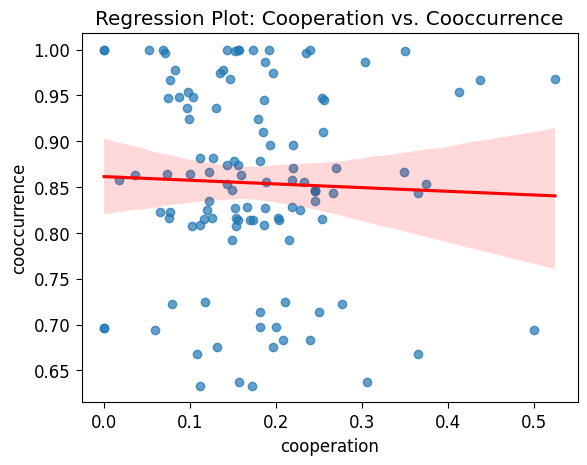

In [ ]:
sns.regplot(x=df["cooperation"], y=df["cooccurrence"], scatter_kws={"alpha": 0.7}, line_kws={"color": "red"})
plt.title("Regression Plot: Cooperation vs. Cooccurrence")
plt.show()

In [ ]:
from scipy.stats import pearsonr, spearmanr
df = pd.DataFrame.from_dict(neg_weight_scores, orient="index")
df = df.astype(float) 
df.head()

pearson_corr, _ = pearsonr(df["cooperation"], df["depletion"])
print("Pearson correlation:", pearson_corr)

# Spearman correlation (if the relationship is non-linear)
spearman_corr, _ = spearmanr(df["cooperation"], df["depletion"])
print("Spearman correlation:", spearman_corr)

Pearson correlation: -0.321522862411514
Spearman correlation: -0.22929268568287528


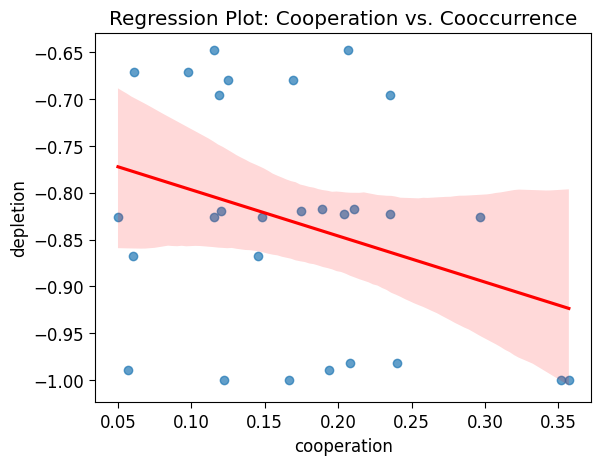

In [ ]:
sns.regplot(x=df["cooperation"], y=df["depletion"], scatter_kws={"alpha": 0.7}, line_kws={"color": "red"})
plt.title("Regression Plot: Cooperation vs. Cooccurrence")
plt.show()

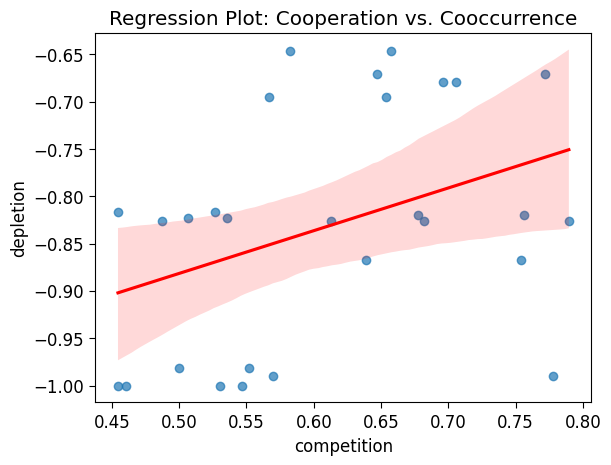

In [ ]:
sns.regplot(x=df["competition"], y=df["depletion"], scatter_kws={"alpha": 0.7}, line_kws={"color": "red"})
plt.title("Regression Plot: Cooperation vs. Cooccurrence")
plt.show()

In [ ]:
def compute_weight_scores(cx_net, parsed_net):
    """
    Computes positive and negative weight scores for a given network.

    Parameters:
        cx_net: Network object containing edges.
        parsed_net: Parsed network dictionary with edge types.

    Returns:
        pos_weight_scores, neg_weight_scores: Dictionaries containing computed scores.
    """

    # Create a mapping of taxa pairs to edge IDs
    taxa_pair_2_edge_id = {
        (edge["s"], edge["t"]): edge_id
        for edge_id in cx_net.get_edges()
        if (edge := cx_net.get_edge(edge_id))["v"]["interaction type"] != "completes/competes with"
    }

    pos_weight_scores, neg_weight_scores = {}, {}

    for edge_id in parsed_net.edge_types["taxon_to_taxon"]["edges"]:
        edge = cx_net.get_edge(edge_id)
        if edge["v"]["interaction type"] in ["cooccurrence", "depletion"]:
            continue

        comp, coop, s, t = edge["v"]["seed::competition"], edge["v"]["seed::cooperation"], edge["s"], edge["t"]
        eid = taxa_pair_2_edge_id.get((s, t), taxa_pair_2_edge_id.get((t, s)))

        flashweave_score = cx_net.get_edge(eid)["v"]["microbetag::weight"]
        target = pos_weight_scores if flashweave_score > 0 else neg_weight_scores
        target[edge_id] = {"cooperation": coop, "competition": comp, "cooccurrence" if flashweave_score > 0 else "depletion": flashweave_score}

    return {"pos": pos_weight_scores, "neg":neg_weight_scores}


In [ ]:
day_cx_objects = {
    "day07": cx_07,
    "day14": cx_14,
    "day21": cx_21,
    "day28": cx_28,
    "day35": cx_35
}

all_scores = {
    day: compute_weight_scores(cx_net, days_parsed_nets[day])
    for day, cx_net in day_cx_objects.items()  # Assuming `cx_objects` stores CX networks for each day
}

In [ ]:
import scipy.stats as stats

def plot_regression(ax, df, x_col, y_col, title):
    """Plots a regression plot on the given Axes object and includes p-value and R-squared."""
    # Perform linear regression to get p-value and R-squared
    slope, intercept, r_value, p_value, std_err = stats.linregress(df[x_col], df[y_col])
    r_squared = r_value**2
    
    # Create the regression plot
    sns.regplot(x=df[x_col], y=df[y_col], scatter_kws={"alpha": 0.7}, line_kws={"color": "red"}, ax=ax)
    
    # Add p-value and R-squared to the title
    ax.set_title(f"{title}\n$R^2$ = {r_squared:.2f}, p-value = {p_value:.4f}")

# def plot_regression(ax, df, x1_col, x2_col, y_col, title, color1="red", color2="blue"):
#     """Plots two regression plots on the same Axes object and includes p-value & R-squared."""
    
#     # First regression (x1_col vs y_col)
#     slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(df[x1_col], df[y_col])
#     r_squared1 = r_value1**2
#     sns.regplot(x=df[x1_col], y=df[y_col], scatter_kws={"alpha": 0.7}, line_kws={"color": color1}, ax=ax, label=f"{x1_col} (R²={r_squared1:.2f}, p={p_value1:.4f})")
    
#     # Second regression (x2_col vs y_col)
#     slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(df[x2_col], df[y_col])
#     r_squared2 = r_value2**2
#     sns.regplot(x=df[x2_col], y=df[y_col], scatter_kws={"alpha": 0.7}, line_kws={"color": color2}, ax=ax, label=f"{x2_col} (R²={r_squared2:.2f}, p={p_value2:.4f})")
    
#     # Titles and legend
#     ax.set_title(title)
#     ax.legend()


def plot_dual_regression(ax, df, x_col, y1_col, y2_col, title, color1="blue", color2="red"):
    """Plots two regressions with separate y-axes: one for y1_col (left) and y2_col (right)."""
    
    # Left Y-axis (cooperation vs cooccurrence)
    ax1 = ax
    slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(df[x_col], df[y1_col])
    r_squared1 = r_value1**2
    sns.regplot(x=df[x_col], y=df[y1_col], scatter_kws={"alpha": 0.7}, line_kws={"color": color1}, ax=ax1)
    ax1.set_ylabel(y1_col, color=color1)
    ax1.tick_params(axis="y", colors=color1)
    
    # Right Y-axis (competition vs cooccurrence)
    ax2 = ax1.twinx()
    slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(df[x_col], df[y2_col])
    r_squared2 = r_value2**2
    sns.regplot(x=df[x_col], y=df[y2_col], scatter_kws={"alpha": 0.3, "color": "red"}, line_kws={"color": color2}, ax=ax2)
    ax2.set_ylabel(y2_col, color=color2)
    ax2.tick_params(axis="y", colors=color2)

    # Titles
    ax1.set_xlabel(x_col)
    ax1.set_title(f"{title}\n{y1_col}: R²={r_squared1:.2f}, p={p_value1:.4f} | {y2_col}: R²={r_squared2:.2f}, p={p_value2:.4f}")




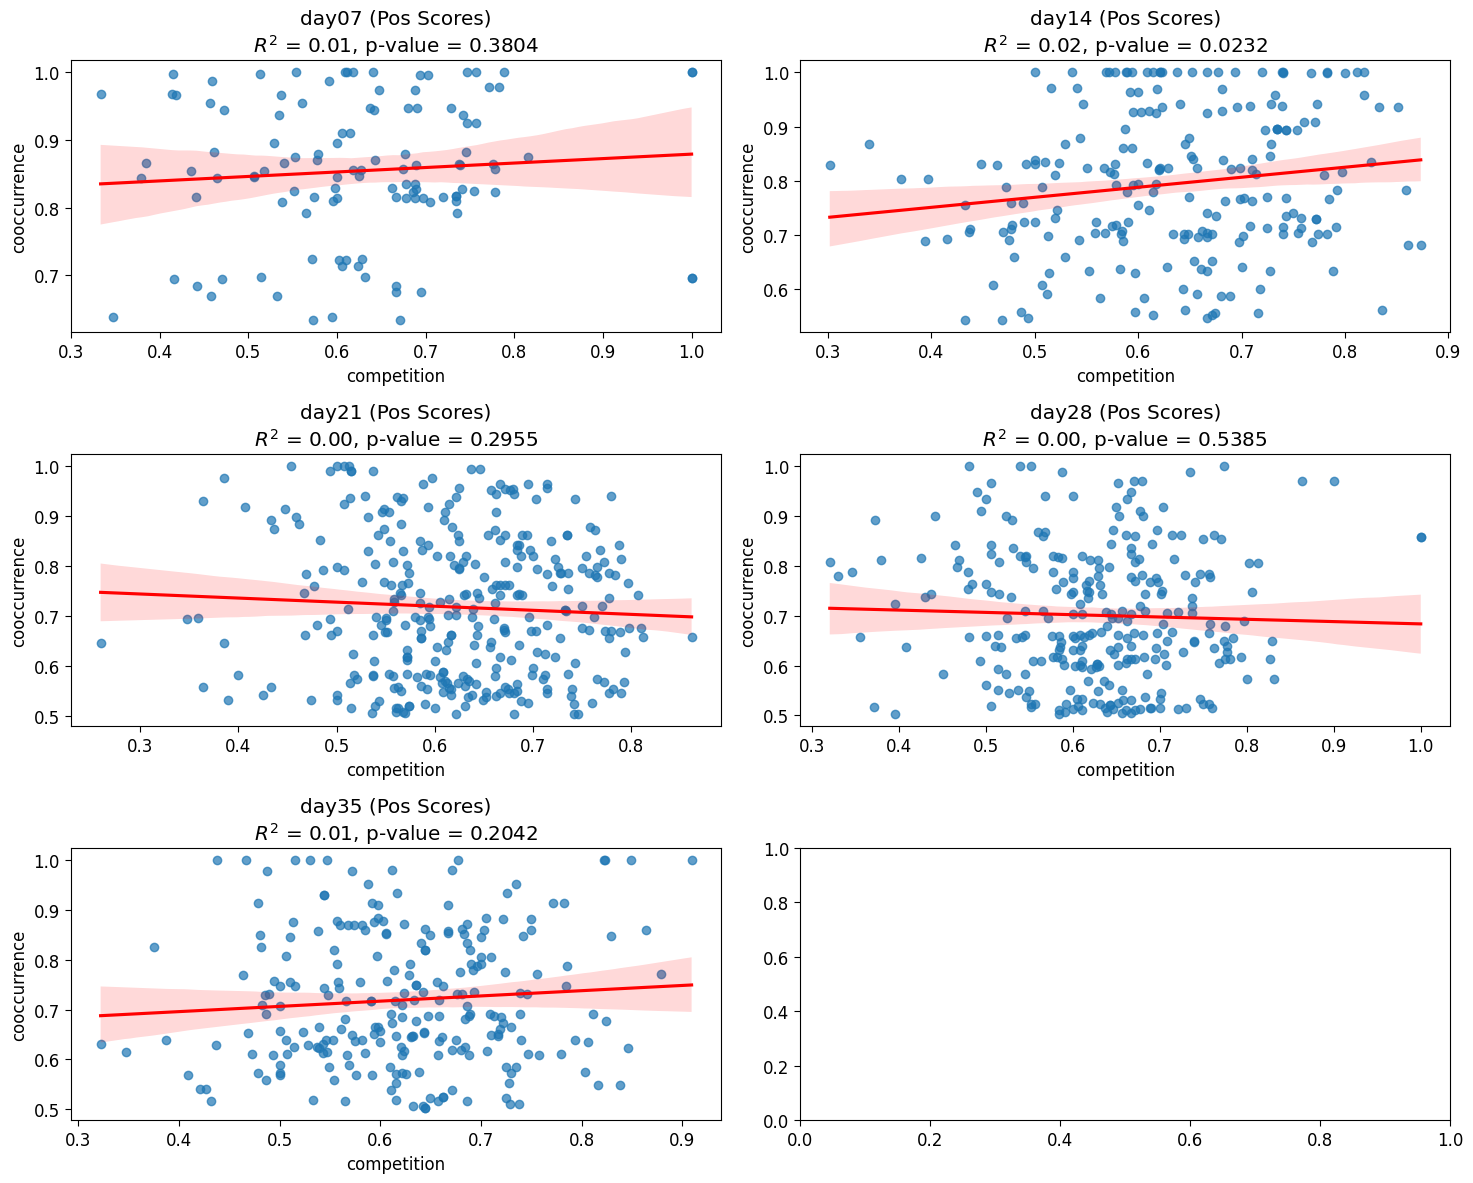

In [ ]:
# Define figure with 3 rows × 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 12))  
axes = axes.flatten()  # Flatten to 1D for easy indexing

# Loop over networks & plot
for i, (day, scores) in enumerate(all_scores.items()):
    if i >= 6:  # Limit to 6 plots (3×2 grid)
        break

    # Handle positive weight scores
    pos_scores = scores["pos"]
    pos_df = pd.DataFrame.from_dict(pos_scores, orient="index")
    pos_df = pos_df.apply(pd.to_numeric, errors="coerce").dropna()  # Ensure numeric values and drop NaN rows
    
    if not pos_df.empty:  # Plot positive weight scores
        plot_regression(axes[i], pos_df, "competition", "cooccurrence", f"{day} (Pos Scores)")
        # plot_regression(axes[i], pos_df, "cooperation", "cooccurrence", f"{day} (Pos Scores)")
        # plot_dual_regression(axes[i], pos_df, "cooccurrence", "cooperation", "competition", f"{day} (Pos Scores)")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

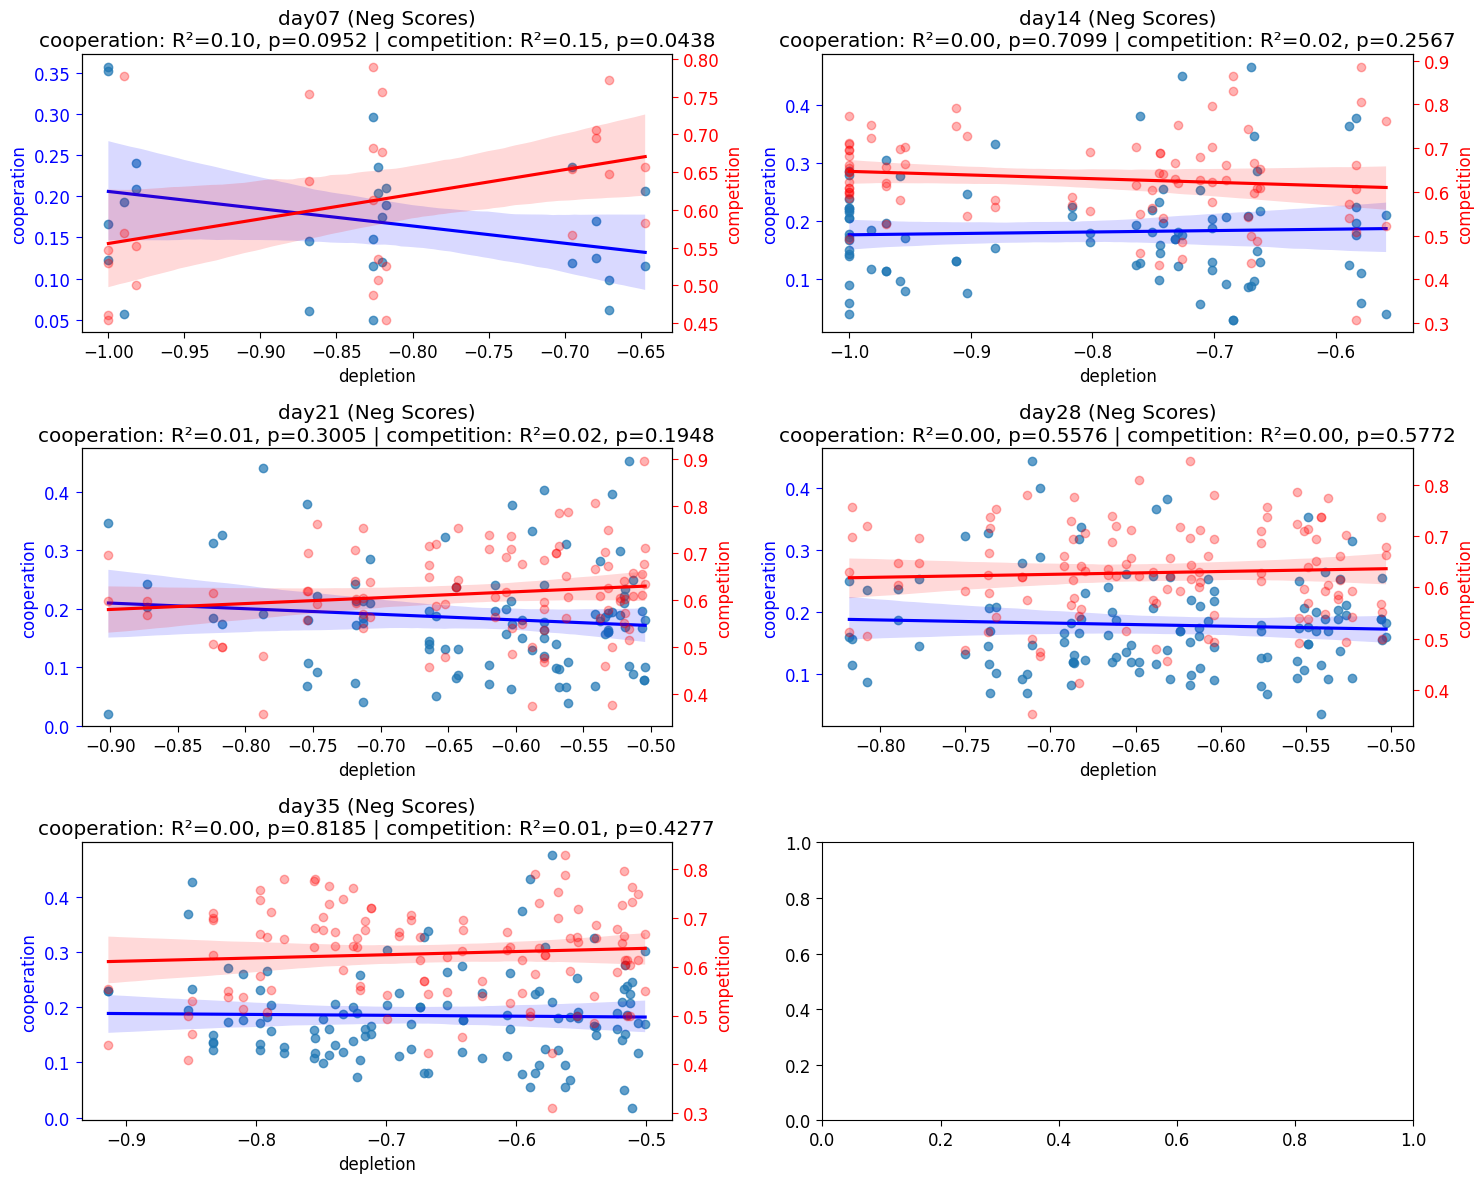

In [ ]:

# Define figure with 3 rows × 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 12))  
axes = axes.flatten()  # Flatten to 1D for easy indexing

# Loop over networks & plot
for i, (day, scores) in enumerate(all_scores.items()):
 
    # Handle negative weight scores (next available subplot)
    neg_scores = scores["neg"]
    neg_df = pd.DataFrame.from_dict(neg_scores, orient="index")
    neg_df = neg_df.apply(pd.to_numeric, errors="coerce").dropna()  # Ensure numeric values and drop NaN rows
    
    if not neg_df.empty:  # Plot negative weight scores in the next available subplot
        if i + 1 < 6:  # Ensure we don't exceed the grid
            # plot_regression(axes[i + 1], neg_df, "competition", "depletion", f"{day} (Neg Scores)")
            # plot_regression(axes[i + 1], neg_df, "cooperation", "depletion", f"{day} (Neg Scores)")
            plot_dual_regression(axes[i], neg_df, "depletion", "cooperation", "competition", f"{day} (Neg Scores)")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

### Per treatment

#### Prep

In [ ]:
cx_tg1_filepath = os.path.join(cx_dir, "microbetag_net_TG1.cx2") ; cx_tg_1 = load_cx2(cx_tg1_filepath)
cx_tg2_filepath = os.path.join(cx_dir, "microbetag_net_TG2.cx2") ; cx_tg_2 = load_cx2(cx_tg2_filepath)
cx_tg3_filepath = os.path.join(cx_dir, "microbetag_net_TG3.cx2") ; cx_tg_3 = load_cx2(cx_tg3_filepath)
cx_tg4_filepath = os.path.join(cx_dir, "microbetag_net_TG4.cx2") ; cx_tg_4 = load_cx2(cx_tg4_filepath)
cx_tg5_filepath = os.path.join(cx_dir, "microbetag_net_TG5.cx2") ; cx_tg_5 = load_cx2(cx_tg5_filepath)

In [ ]:
treatment_parsed_nets = {
    "TG1" : MggParser(cx_tg_1, env_set, metabolites_set),
    "TG2" : MggParser(cx_tg_2, env_set, metabolites_set),
    "TG3" : MggParser(cx_tg_3, env_set, metabolites_set),
    "TG4" : MggParser(cx_tg_4, env_set, metabolites_set),
    "TG5" : MggParser(cx_tg_5, env_set, metabolites_set)
}

In [ ]:
treatment_cx_objects = {
    "TG1": cx_tg_1,
    "TG2": cx_tg_2,
    "TG3": cx_tg_3,
    "TG4": cx_tg_4,
    "TG5": cx_tg_5
}

In [ ]:
all_scores_treatments = {
    treatment: compute_weight_scores(cx_net, treatment_parsed_nets[treatment])
    for treatment, cx_net in treatment_cx_objects.items()  # Assuming `cx_objects` stores CX networks for each day
}

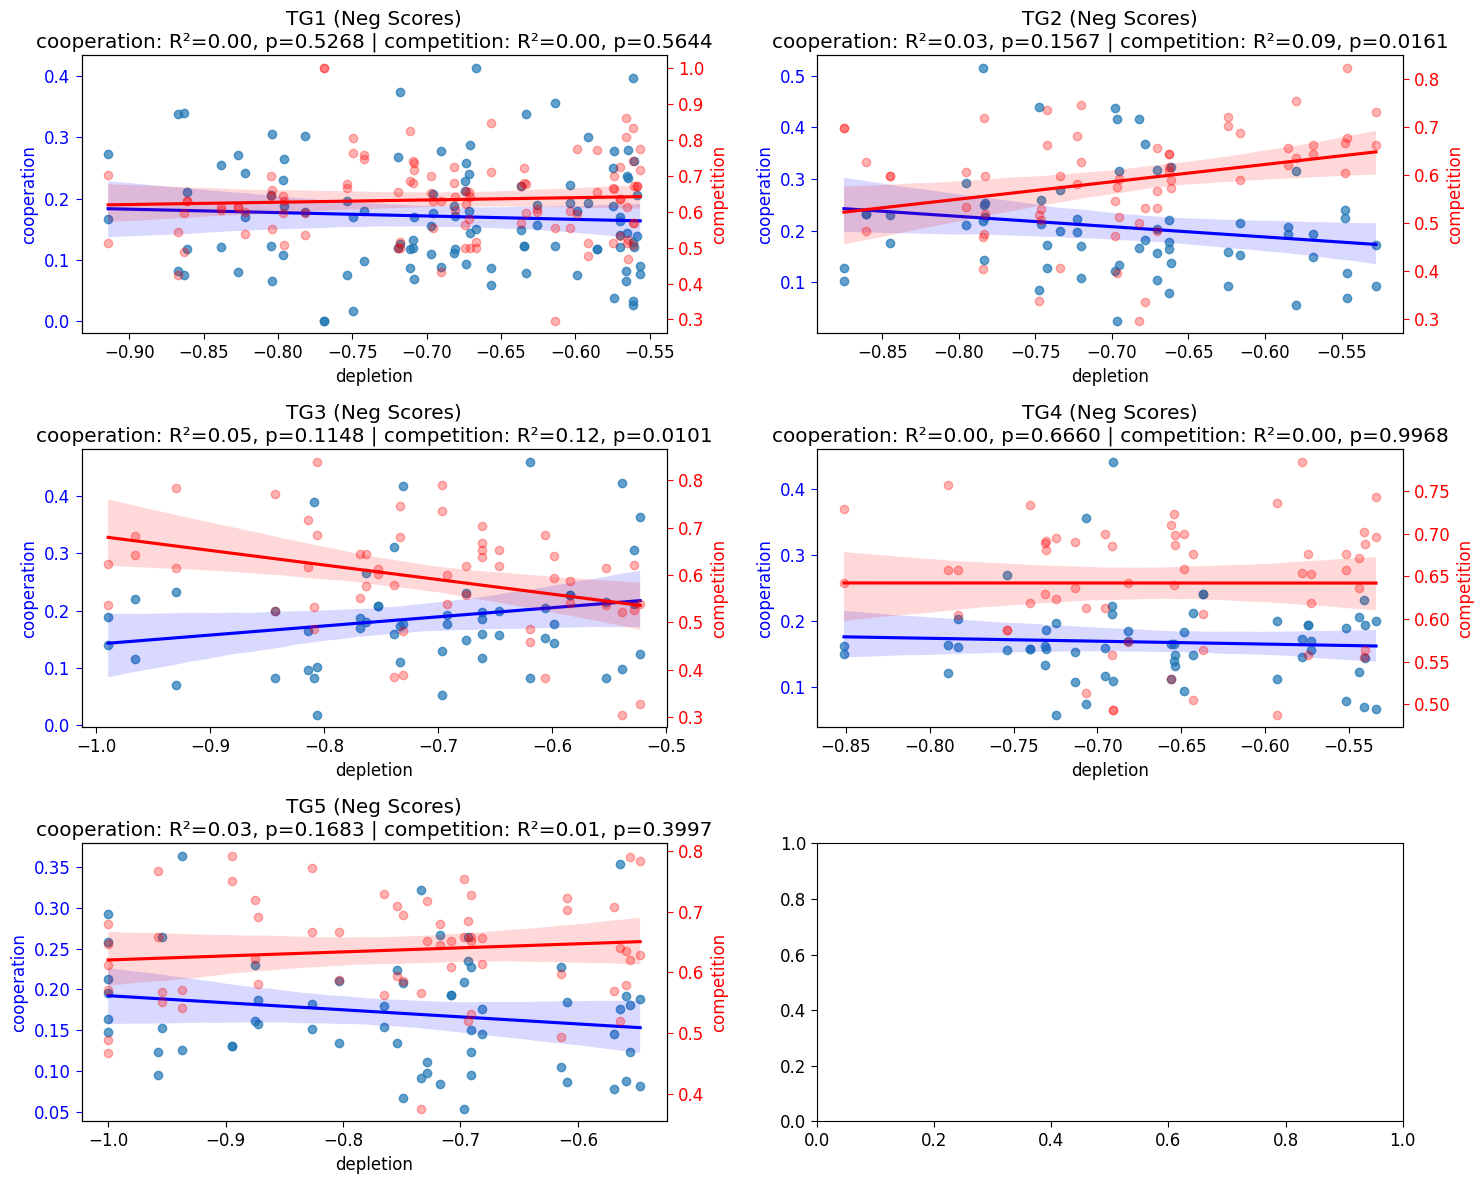

In [ ]:
# Define figure with 3 rows × 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 12))  
axes = axes.flatten()  # Flatten to 1D for easy indexing

# Loop over networks & plot
for i, (day, scores) in enumerate(all_scores_treatments.items()):
    if i >= 6:  # Limit to 6 plots (3×2 grid)
        break

    # Handle negative weight scores (next available subplot)
    neg_scores = scores["neg"]
    neg_df = pd.DataFrame.from_dict(neg_scores, orient="index")
    neg_df = neg_df.apply(pd.to_numeric, errors="coerce").dropna()  # Ensure numeric values and drop NaN rows
    
    if not neg_df.empty:  # Plot negative weight scores in the next available subplot
        if i + 1 < 6:  # Ensure we don't exceed the grid
            # plot_regression(axes[i + 1], neg_df, "competition", "depletion", f"{day} (Neg Scores)")
            plot_dual_regression(axes[i], neg_df, "depletion", "cooperation", "competition", f"{day} (Neg Scores)")

            

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

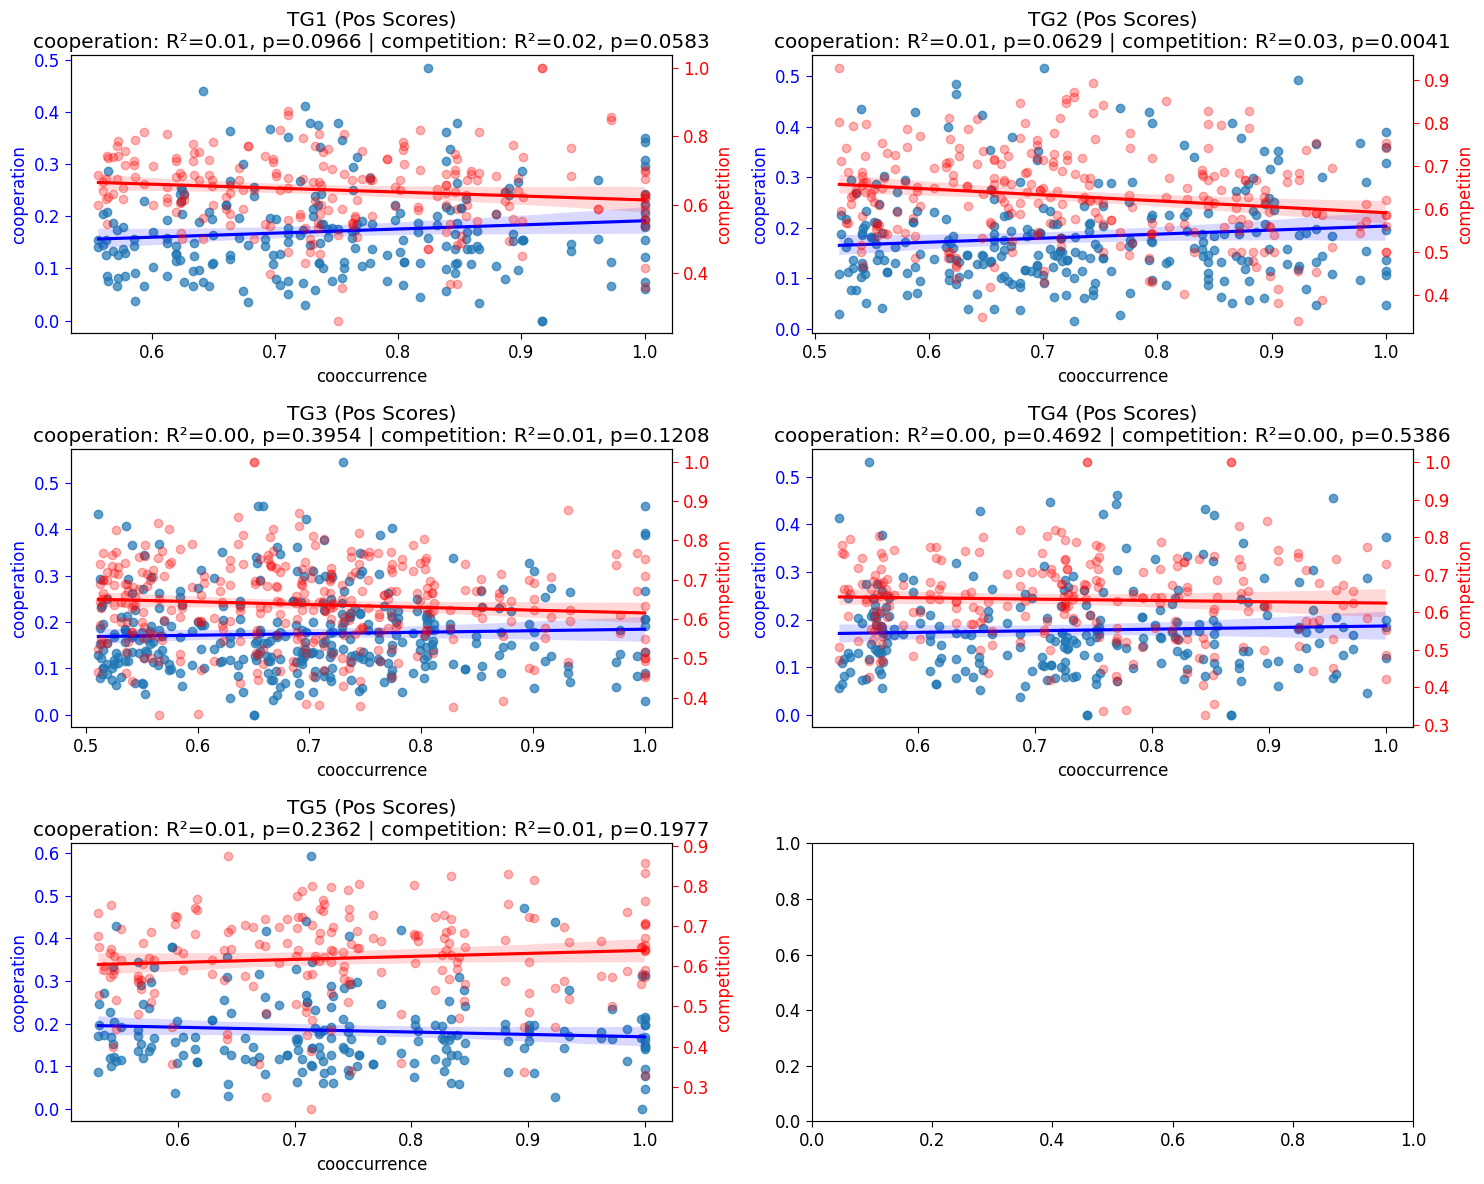

In [ ]:
# Define figure with 3 rows × 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 12))  
axes = axes.flatten()  # Flatten to 1D for easy indexing

# Loop over networks & plot
for i, (day, scores) in enumerate(all_scores_treatments.items()):
    if i >= 6:  # Limit to 6 plots (3×2 grid)
        break
    # Handle positive weight scores
    pos_scores = scores["pos"]
    pos_df = pd.DataFrame.from_dict(pos_scores, orient="index")
    pos_df = pos_df.apply(pd.to_numeric, errors="coerce").dropna()  # Ensure numeric values and drop NaN rows
    if not pos_df.empty:  # Plot positive weight scores
        # plot_regression(axes[i], pos_df, "cooperation", "cooccurrence", f"{day} (Pos Scores)")
        plot_dual_regression(axes[i], pos_df, "cooccurrence", "cooperation", "competition", f"{day} (Pos Scores)")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [ ]:
pos_df

,cooperation,competition,cooccurrence
1,0.169231,0.641975,0.542909
2,0.100000,0.753623,0.542909
4,0.181818,0.697368,0.930933
5,0.142857,0.563830,0.930933
7,0.254237,0.641791,0.639670
...,...,...,...
377,0.283333,0.600000,0.742562
379,0.241379,0.647059,0.845697
380,0.153846,0.556962,0.845697
382,0.246377,0.604651,0.570273


In [ ]:
tg_microbetag_nets = [cx_tg_1, cx_tg_2, cx_tg_3, cx_tg_4, cx_tg_5]
treatments = ["TG1", "TG2", "TG3", "TG4", "TG5"]
treatments_descr = [
    "TG1:Salmonella, synbiont both water and feed",
    "TG2:Salmonella, synbiont in water",
    "TG3:Salmonella, synbiont in feed",
    "TG4:Salmonella, no symbiont",
    "TG5:No Salmonella, no symbiont"
]

In [ ]:
parsed_tg_edges = []
for tg_mgg_net in tg_microbetag_nets:
    num_compl, types, pos_pairs, compounds = parse_microbetag_edges(tg_mgg_net, env_set=env_set, metabolites_set=metabolites_set)
    parsed_tg_edges.append([num_compl, types, pos_pairs, compounds])

#### Count the number of **taxon-metabolite associations** in the day-specific networks and correlate it with day

In [ ]:
taxon_to_metabo_hits = [
    net.edge_types["taxon_to_metabo"]["counts"] for _, net in treatment_parsed_nets.items()
]

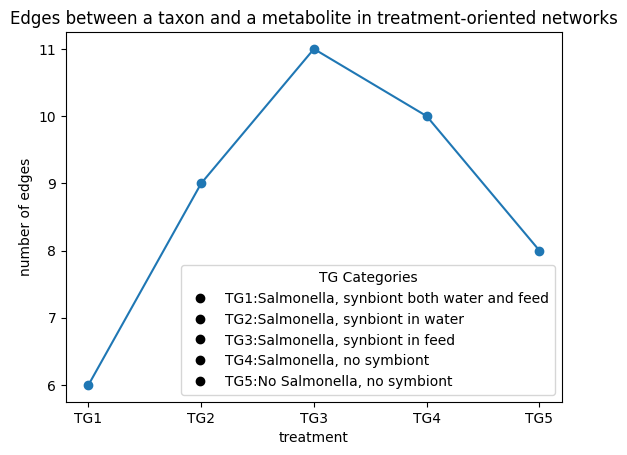

In [ ]:
plt.plot(treatments, taxon_to_metabo_hits, marker='o', linestyle='-')
# Labels and title
plt.xlabel("treatment")
plt.ylabel("number of edges")
plt.title("Edges between a taxon and a metabolite in treatment-oriented networks")
# Create proxy artists for legend
legend_handles = [mlines.Line2D([], [], color='black', marker='o', linestyle='None', label=t) for t in treatments_descr]
# Add legend box
plt.legend(handles=legend_handles, title="TG Categories", loc="lower right", frameon=True)
plt.show()


#### Count the number of taxon-treatment associations in the day-specific networks

In [ ]:
taxon_to_env_hits = [
    net.edge_types["taxon_to_env"]["counts"] for _, net in treatment_parsed_nets.items()
]

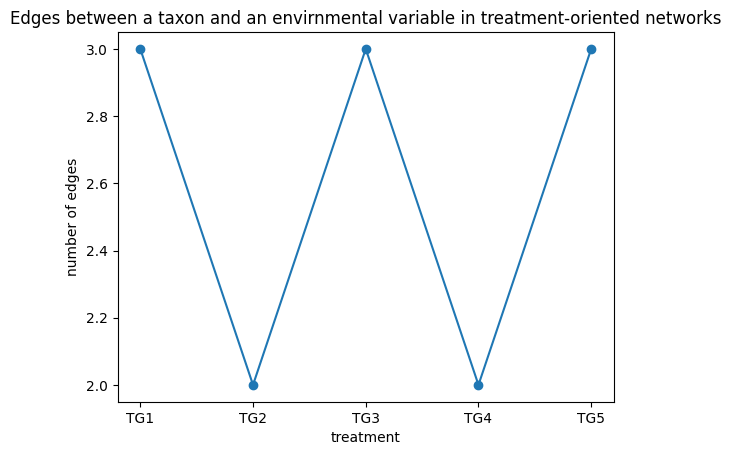

In [ ]:
plt.plot(treatments, taxon_to_env_hits, marker='o', linestyle='-')
# Labels and title
plt.xlabel("treatment")
plt.ylabel("number of edges")
plt.title("Edges between a taxon and an envirnmental variable in treatment-oriented networks")

plt.show()

#### Correlate time vs total number of cross-feedings across day-specific networks

In [ ]:
overall_number_of_seed_compl = [
    sum(net.num_total_compls.values()) for _, net in treatment_parsed_nets.items()
]

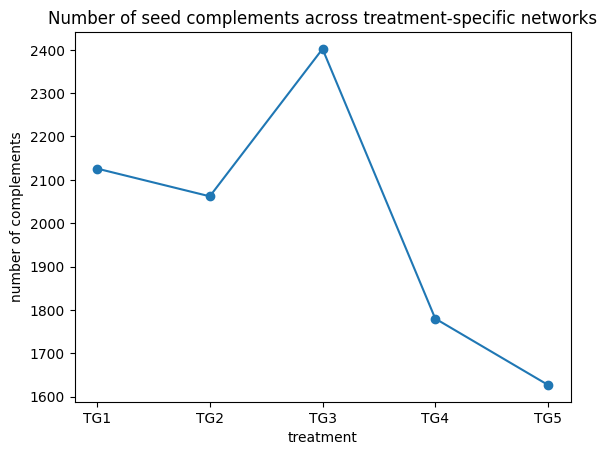

In [ ]:
plt.plot(treatments, overall_number_of_seed_compl, marker='o', linestyle='-')

# Labels and title
plt.xlabel("treatment")
plt.ylabel("number of complements")
plt.title("Number of seed complements across treatment-specific networks")

# Show the plot
plt.show()

#### Correlation between number of positive taxon-to-taxon edged and predicted cross-feedings in day-specific networks 

In [ ]:
number_of_seed_compl_per_day_in_positive_associated_taxa = [
    get_compls_and_compounds_in_positive_associated_taxa(
        net.cx2, 
        net.pos_pairs_node_ids, 
        net.num_total_compls, 
        net.edge_id_to_unique_compounds
        )[0] 
    for _, net in treatment_parsed_nets.items()
]

NameError: name 'treatment_parsed_nets' is not defined

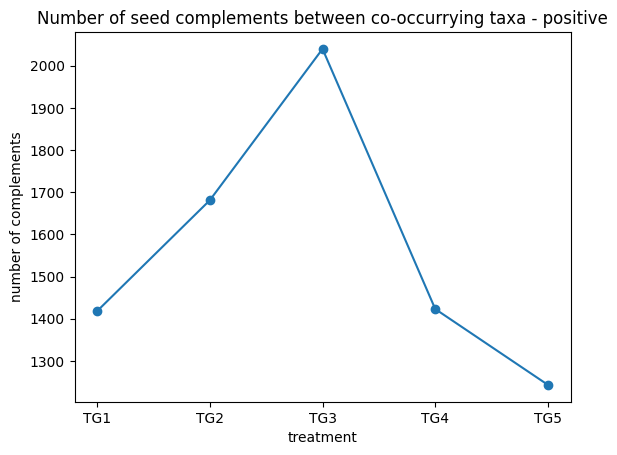

In [ ]:
plt.plot(treatments, number_of_seed_compl_per_day_in_positive_associated_taxa, marker='o', linestyle='-')

# Labels and title
plt.xlabel("treatment")
plt.ylabel("number of complements")
plt.title("Number of seed complements between co-occurrying taxa - positive")

# Show the plot
plt.show()

In [ ]:
mean_of_seed_compl_in_positive_associated_taxa = [
    number_of_seed_compl_per_day_in_positive_associated_taxa[index] / len(net.pos_pairs_node_ids) for index, net in enumerate(treatment_parsed_nets.values())
]
mean_overall_number_of_seed_compl = [
    overall_number_of_seed_compl[index] /  len(net.num_total_compls)  for index, net in enumerate(treatment_parsed_nets.values())
]

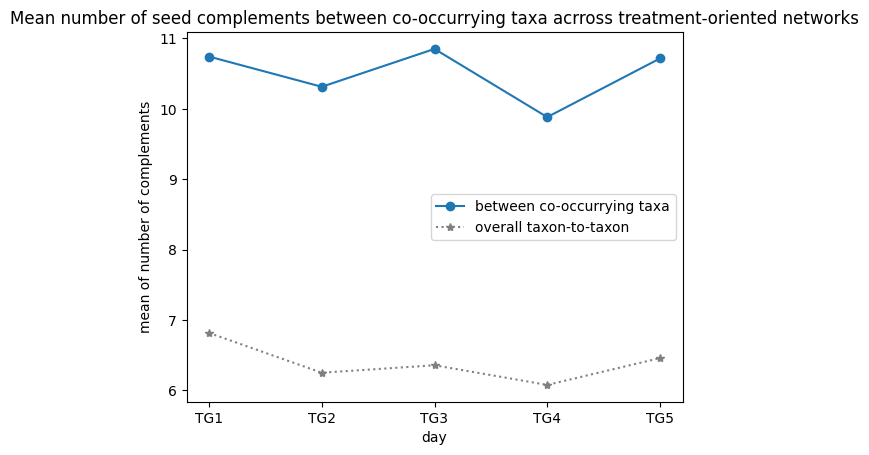

In [ ]:
plt.plot(treatments, mean_of_seed_compl_in_positive_associated_taxa, marker='o', linestyle='-', label="between co-occurrying taxa")
plt.plot(treatments, mean_overall_number_of_seed_compl, marker="*", linestyle="dotted", color="grey", label="overall taxon-to-taxon")

# Labels and title
plt.xlabel("day")
plt.ylabel("mean of number of complements")
plt.title("Mean number of seed complements between co-occurrying taxa acrross treatment-oriented networks")

plt.legend()

# Show the plot
plt.show()

#### Unique compounds involved in potential cross-feedings of co-occurrying taxa

In [ ]:
unique_compounds_in_cf_of_positive_associated_taxa = [
    get_compls_and_compounds_in_positive_associated_taxa(
        net.cx2, 
        net.pos_pairs_node_ids, 
        net.num_total_compls, 
        net.edge_id_to_unique_compounds
        )[1]
    for _, net in treatment_parsed_nets.items()
]

lengths = [
    len(x) for x in unique_compounds_in_cf_of_positive_associated_taxa
]

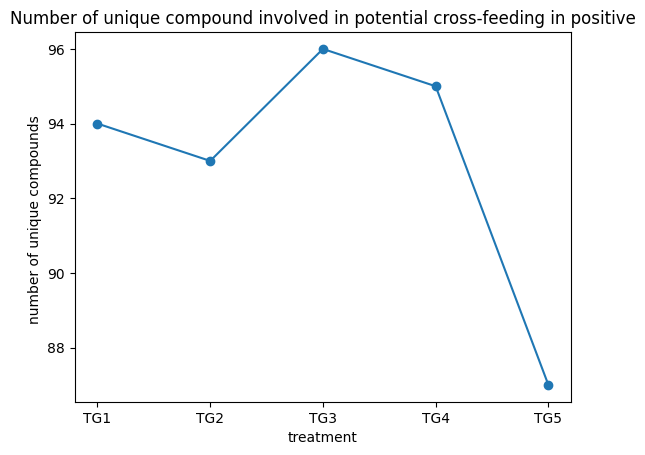

In [ ]:
plt.plot(treatments, lengths, marker='o', linestyle='-')

# Labels and title
plt.xlabel("treatment")
plt.ylabel("number of unique compounds ")
plt.title("Number of unique compound involved in potential cross-feeding in positive")

# Show the plot
plt.show()

In [ ]:
treatment_set = { i: j for i,j in zip(treatments, unique_compounds_in_cf_of_positive_associated_taxa)}

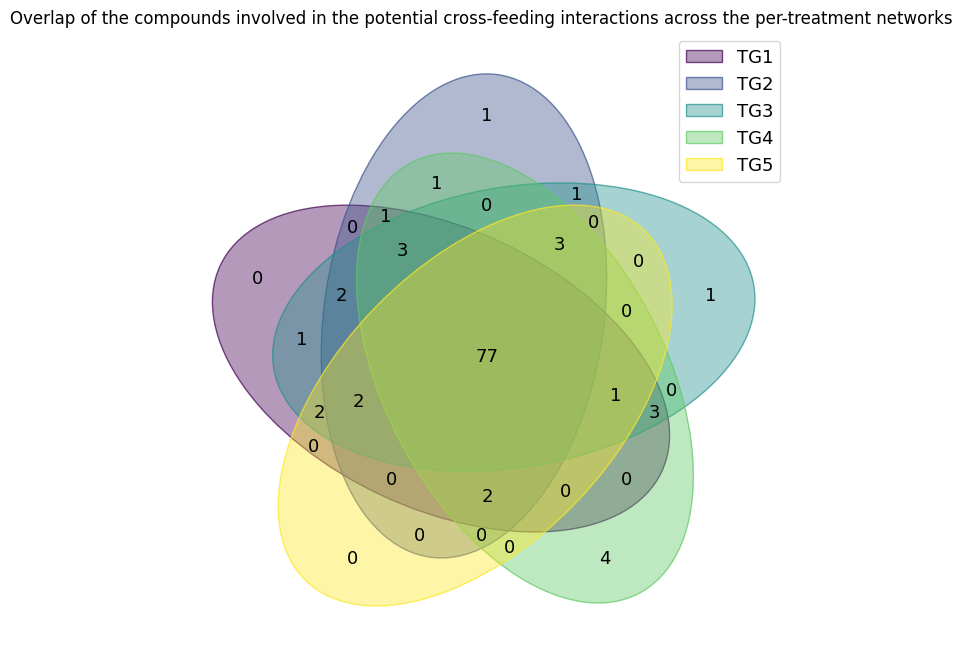

In [ ]:
venn(treatment_set)
plt.title("Overlap of the compounds involved in the potential cross-feeding interactions across the per-treatment networks")

# Show the plot
plt.show()